In [165]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import fetch_olivetti_faces
from torch.utils.data import DataLoader

In [166]:
# 下载数据
olivetti_faces = fetch_olivetti_faces(data_home='./olivetti', shuffle=True)
# print(olivetti_faces.data.shape)
# print(olivetti_faces.target.shape)
# print(olivetti_faces.images.shape)

In [ ]:
# 查看数据，40个target（人脸），每人10个
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
index = 1
for i in range(0,100,1):
    plt.subplot(10, 10, index)
    index += 1
    plt.imshow(olivetti_faces.images[i], cmap='gray')
    plt.title(f"{olivetti_faces.target[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [167]:
# 引入模型
# from olivettiface_model import olivettiface_model
# model1 = olivettiface_model()
device = "cuda" if torch.cuda.is_available() else "cpu"
model = nn.Sequential(
    nn.Linear(4096, 2048),
    nn.BatchNorm1d(2048),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(2048, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(1024, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(512, 40)
).to(device)

In [173]:
# 超参数
LR = 1e-3
EPOCHS = 150
# BATCH_SIZE = 10 总共就400个数据，不用Dataloader

In [174]:
#损失函数
loss_fn = nn.CrossEntropyLoss()
#优化器
# sgd = optim.SGD(params=model.parameters(),lr=LR)    #原始sgd
# sgd_monment = optim.SGD(params=model.parameters(),lr=LR,momentum=0.5,weight_decay=1e-4)   #加入动量、权重衰减
# adam = optim.Adam(params=model.parameters(),lr=LR,weight_decay=1e-4)
# adamW = optim.AdamW(params=model.parameters(),lr=LR,weight_decay=1e-4)

In [175]:
origin_input = torch.tensor(olivetti_faces.data)
trarin_data = origin_input[:300] 
test_data = origin_input[300:400]
target = torch.tensor(olivetti_faces.target).long()


In [176]:
def train(epoches, model, input, target, loss_fn, optimizer_order):
    loss_his = []
    #优化器
    sgd = optim.SGD(params=model.parameters(),lr=LR)    #原始sgd
    sgd_monment = optim.SGD(params=model.parameters(),lr=LR,momentum=0.5,weight_decay=1e-4)   #加入动量、权重衰减
    adam = optim.Adam(params=model.parameters(),lr=LR,weight_decay=1e-4)
    adamW = optim.AdamW(params=model.parameters(),lr=LR,weight_decay=1e-4)
    if optimizer_order == 1:
        optimizer = sgd
    elif optimizer_order == 2:
        optimizer = sgd_monment
    elif optimizer_order == 3:
        optimizer = adam
    elif optimizer_order == 4:
        optimizer = adamW
    for i in range(epoches):
        output = model(input)
        loss = loss_fn(output, target)
        loss_his.append(loss.item())
        model.zero_grad()
        loss.backward()
        optimizer.step()
    return loss_his

In [177]:
#创建4个相同的model
models = nn.ModuleList([nn.Sequential(
    nn.Linear(4096, 2048),
    nn.BatchNorm1d(2048),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(2048, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(1024, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(512, 40)
).to(device) for _ in range(4)])

In [181]:
train_hists = [train(epoches=EPOCHS, model=m, input=trarin_data.to(device), target=target[:300].to(device), loss_fn=loss_fn, optimizer_order=order)
               for m,order in zip(models,[1,2,3,4])]

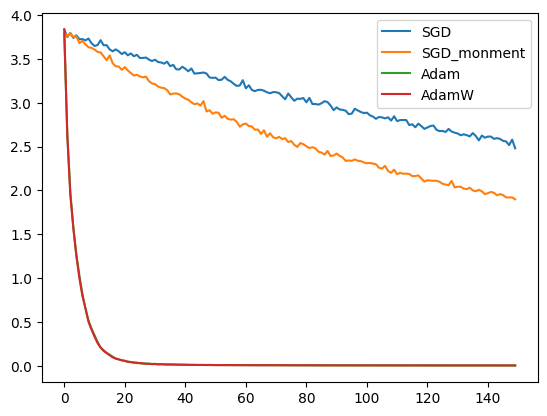

[3.8352832794189453, 3.7487056255340576, 3.7942395210266113, 3.739579677581787, 3.7690625190734863, 3.7236242294311523, 3.7257962226867676, 3.711397409439087, 3.731769561767578, 3.6787490844726562, 3.6473186016082764, 3.6572773456573486, 3.713160753250122, 3.6558706760406494, 3.6560330390930176, 3.6076958179473877, 3.586557626724243, 3.6082539558410645, 3.5863687992095947, 3.554898738861084, 3.5760295391082764, 3.5401036739349365, 3.562235116958618, 3.530441999435425, 3.5458321571350098, 3.5100133419036865, 3.510611057281494, 3.5149288177490234, 3.4918224811553955, 3.4751136302948, 3.4904236793518066, 3.4642679691314697, 3.458477258682251, 3.4453067779541016, 3.467939853668213, 3.4163951873779297, 3.4315178394317627, 3.380959987640381, 3.379148244857788, 3.410385847091675, 3.3867995738983154, 3.3580880165100098, 3.3908863067626953, 3.3319809436798096, 3.3356244564056396, 3.338789224624634, 3.3445773124694824, 3.3330016136169434, 3.288557529449463, 3.2829067707061768, 3.2859690189361572

In [182]:

import matplotlib.pyplot as plt
import numpy as np
plot_y = np.arange(0,EPOCHS,1)
plt.plot(plot_y, train_hists[0], label='SGD')
plt.plot(plot_y, train_hists[1], label='SGD_monment')
plt.plot(plot_y, train_hists[2], label='Adam')
plt.plot(plot_y, train_hists[3], label='AdamW')
plt.legend()
plt.show()

print(train_hists[0])
print(train_hists[1])
print(train_hists[2])
print(train_hists[3])

In [183]:
#准确率
def test(model, input, target):
    with torch.no_grad():
        output = model(input)
        _,predicted = torch.max(output,1)
        correct = (predicted==target).sum().item()
        rate = correct/target.size(0)
        print(f'predicted={predicted==target}\nrate={rate}')
        return rate

In [184]:
test(models[0], test_data, target[300:400])
test(models[1], test_data, target[300:400])
test(models[2], test_data, target[300:400])
test(models[3], test_data, target[300:400])

predicted=tensor([False, False, False,  True, False, False,  True,  True,  True,  True,
         True, False,  True,  True, False, False, False,  True, False, False,
        False, False, False,  True,  True, False, False, False, False,  True,
        False, False,  True,  True,  True,  True,  True, False, False, False,
         True,  True,  True,  True, False,  True, False, False,  True, False,
        False, False, False, False, False, False, False,  True, False,  True,
         True,  True, False,  True, False, False, False, False,  True, False,
        False,  True,  True,  True,  True, False,  True, False, False, False,
        False, False, False, False, False,  True, False, False,  True,  True,
        False, False,  True, False, False,  True, False, False, False, False])
rate=0.39
predicted=tensor([False, False, False,  True, False, False,  True, False, False, False,
        False,  True,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True, False,  Tru

0.95

In [185]:
test(model, test_data, target[300:400])

predicted=tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
         True, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False,  True, False])
rate=0.03


0.03